In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.compat.v1.nn import rnn_cell
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [3]:
datos=pd.read_csv('N225_Limpiado_Actual')
cierre=datos['Close'].values.astype('float32')
datos
cierre

array([10654.79, 10681.83, 10731.45, ..., 40168.07, 40369.44, 39803.09],
      dtype=float32)

<function matplotlib.pyplot.show(close=None, block=None)>

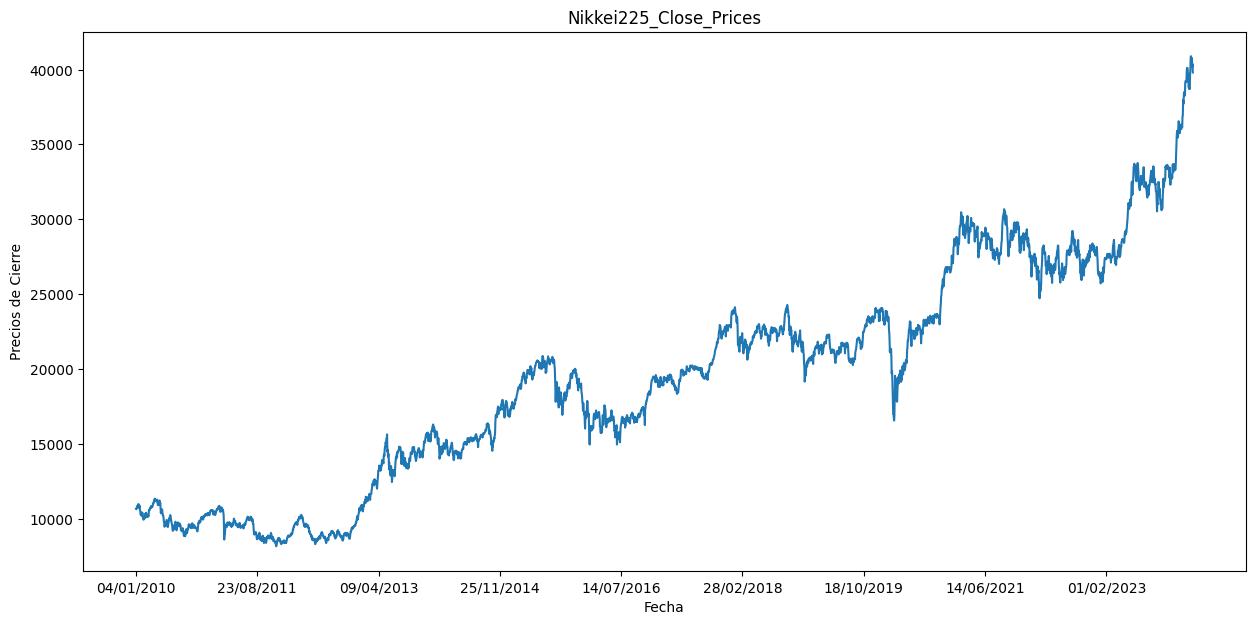

In [4]:
plt.figure(figsize=(15,7))
plt.plot(cierre)
plt.title("Nikkei225_Close_Prices")
plt.xlabel("Fecha")
plt.xticks(range(0,len(datos['Date']),400),datos['Date'][0::400])
plt.ylabel("Precios de Cierre")
plt.show

In [5]:
#Preprocesamiento de los datos

datos_escalados=preprocessing.MinMaxScaler().fit_transform(cierre.reshape(-1,1)).squeeze()
datos_escalados

array([0.07622673, 0.07705291, 0.07856904, ..., 0.9779898 , 0.98414254,
       0.966838  ], dtype=float32)

In [6]:
#Distribución de datos
def data_generator(data, window , distance=0):
    x=[]
    y=[]
    for i in range(len(data)-window-distance):
        x.append(data[i:i+window])
        y.append(data[i+window+distance])
    return np.array(x),np.array(y)

In [7]:
Train_size=int(len(datos_escalados)*0.7)
Test_size=int(len(datos_escalados)*0.2)
Val_size=int(len(datos_escalados)-Train_size-Test_size)

Train_data=datos_escalados[:Train_size]
Test_data=datos_escalados
Val_data=datos_escalados[Train_size:Train_size+Val_size]

Sizeof_block=50

#Generacion de los datos para analisis
train_x,train_y=data_generator(Train_data,Sizeof_block,0)
print(f'\n Datos de entrenamiento: \t Train_x: {train_x.shape} \t Train_y: {train_y.shape}')

test_x,test_y=data_generator(Test_data, Sizeof_block , 0)
print(f'\n Datos de prueba: \t Test_x: {test_x.shape} \t Test_y: {test_y.shape}')

validation_x,validation_y=data_generator(Val_data,Sizeof_block , 0)
print(f'\n Datos de validación: \t Validation_x: {validation_x.shape} \t Validation_y: {validation_y.shape}')


 Datos de entrenamiento: 	 Train_x: (2390, 50) 	 Train_y: (2390,)

 Datos de prueba: 	 Test_x: (3436, 50) 	 Test_y: (3436,)

 Datos de validación: 	 Validation_x: (299, 50) 	 Validation_y: (299,)


#Primer Modelo Propuesto

In [9]:
def redLSTM1(bloque,epocas):

  Sizeblock=bloque

  train_x,train_y=data_generator(Train_data,Sizeblock,0)
  test_x,test_y=data_generator(Test_data,Sizeblock,0)
  val_x,val_y=data_generator(Val_data,Sizeblock,0)

  RNN=tf.keras.Sequential()
  RNN.add(tf.keras.layers.LSTM(
      units=1,
      input_shape=(Sizeblock,1),
      activation='tanh'
  ))
  #RNN.add(tf.keras.layers.Dense(1,activation='softmax'))

  RNN.summary()
  RNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
  early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

  train_x=np.reshape(train_x,(train_x.shape[0], train_x.shape[1],1))
  test_x=np.reshape(test_x,(test_x.shape[0],test_x.shape[1],1))

  history=RNN.fit(train_x, train_y,
                  epochs=epocas,
                  batch_size=int(Sizeblock/2),
                  callbacks=[early_stop],
                  validation_data=(val_x,val_y))

  predicciones=RNN.predict(test_x,verbose=True)

  plt.figure(figsize=(9,5))
  plt.plot(history.history['loss'], '-.',label='Perdida Entrenamiento')
  plt.plot(history.history['val_loss'], '-',label='Perdida Prueba')
  plt.title(f'Modelo de perdida para red LSTM 1')
  plt.xlabel('Época')
  plt.ylabel('Precisión')
  plt.legend()
  plt.show()

  return predicciones

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
486/486 [==============================] - 5s 5ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 2/10
486/486 [==============================] - 2s 4ms/step - loss: 9.7704e-04 - mean_squared_error: 9.7704e-04 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 3/10
486/486 [==============================] - 2s 4ms/step - loss: 2.4397e-04 - mean_squared_error: 2.4397e-04 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 4/10
486/486 [============================

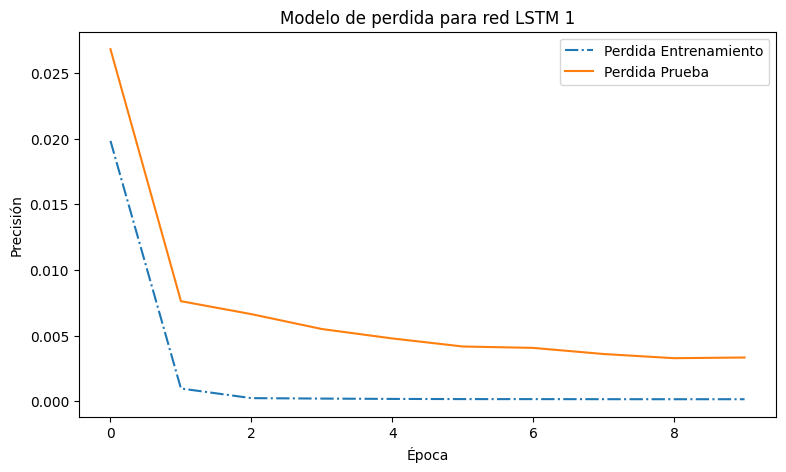

In [10]:
predicciones_m1=redLSTM1(10,10)

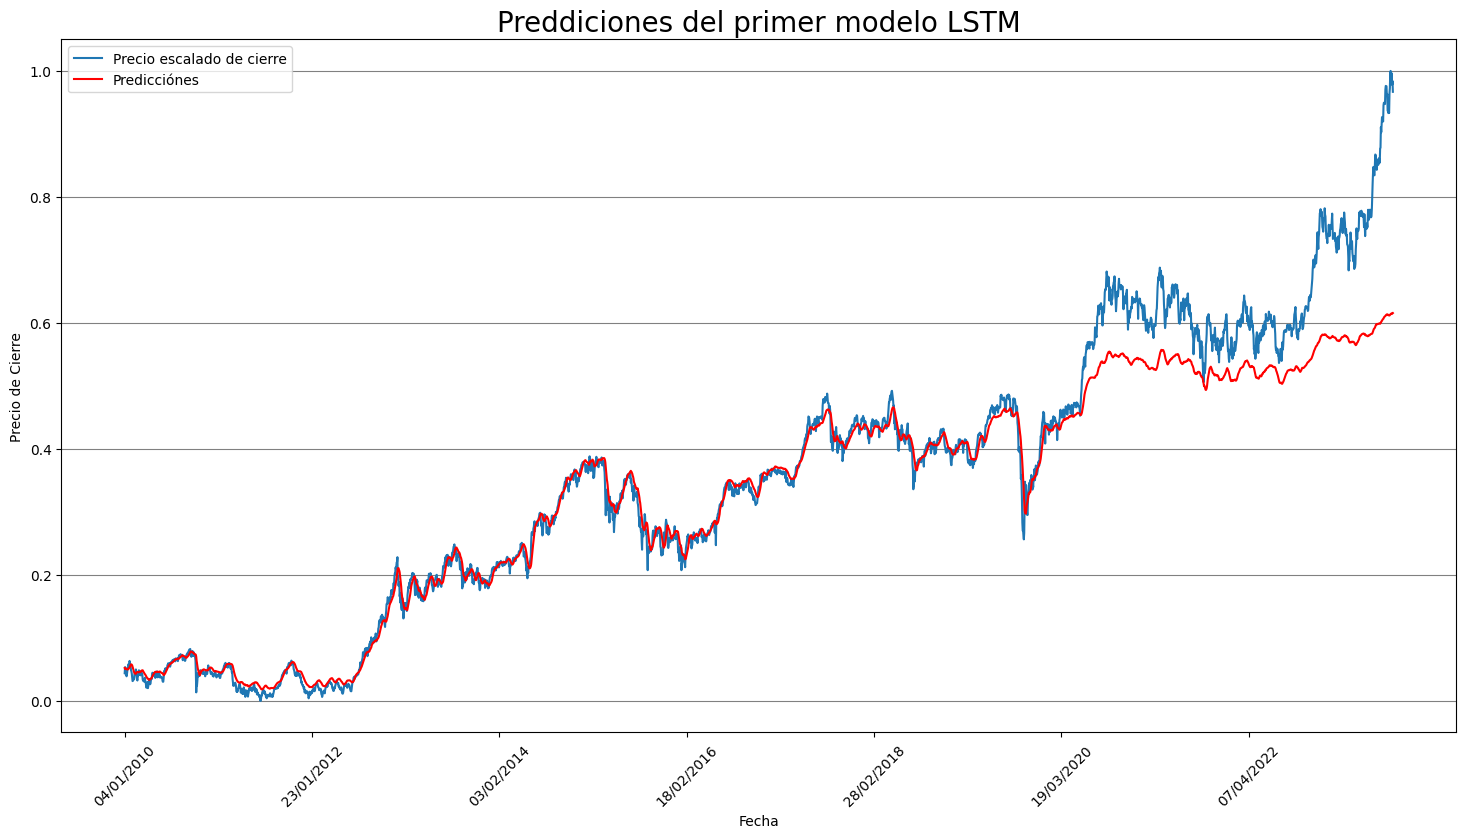

In [11]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),predicciones_m1[90:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
486/486 [==============================] - 4s 5ms/step - loss: 8.2915e-04 - mean_squared_error: 8.2915e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2/20
486/486 [==============================] - 2s 5ms/step - loss: 3.5648e-04 - mean_squared_error: 3.5648e-04 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 3/20
486/486 [==============================] - 2s 4ms/step - loss: 2.0909e-04 - mean_squared_error: 2.0909e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 4/20
486/486 [==================

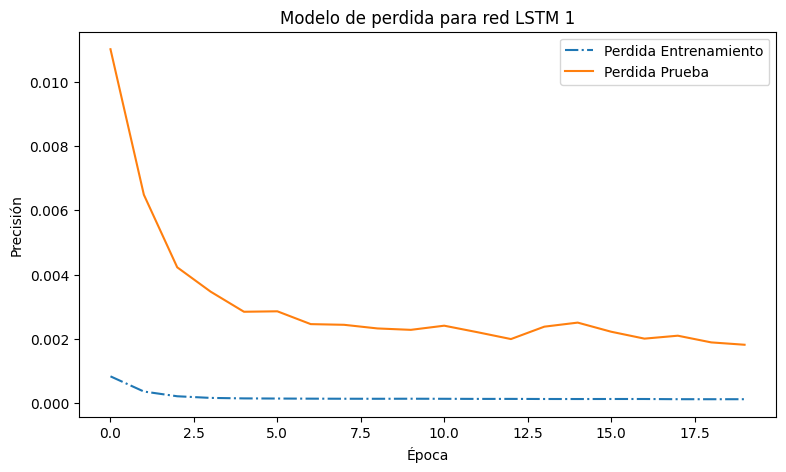

In [12]:
predicciones2_m1=redLSTM1(10,20)

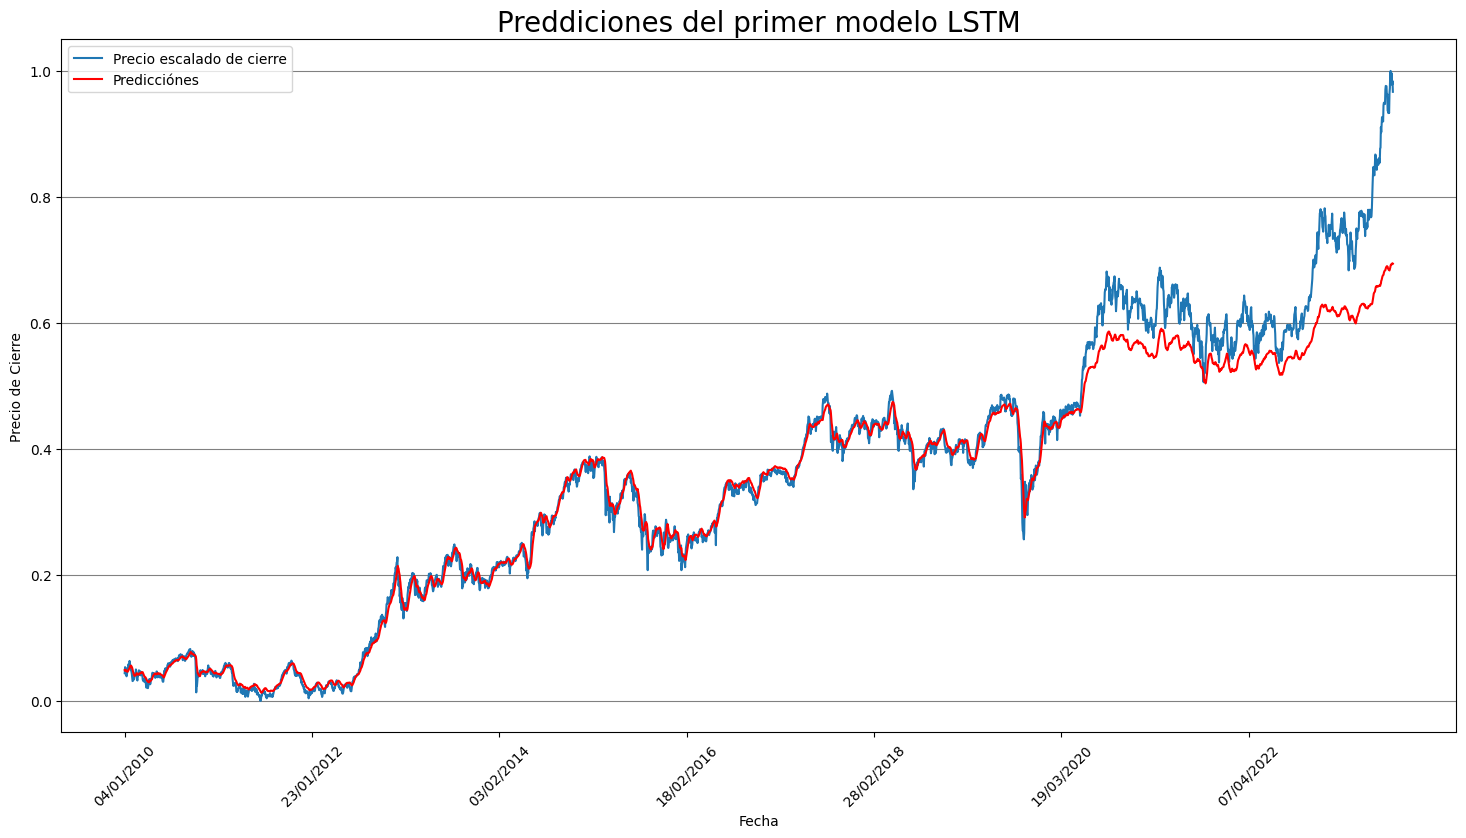

In [13]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),predicciones2_m1[90:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
486/486 [==============================] - 5s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 2/30
486/486 [==============================] - 2s 4ms/step - loss: 1.7928e-04 - mean_squared_error: 1.7928e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 3/30
486/486 [==============================] - 2s 4ms/step - loss: 7.2979e-05 - mean_squared_error: 7.2979e-05 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/30
486/486 [==========================

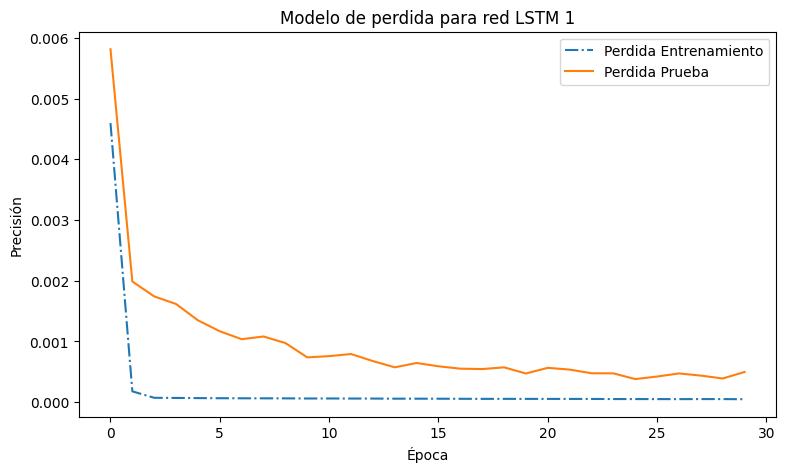

In [14]:
predicciones3_m1=redLSTM1(10,30)

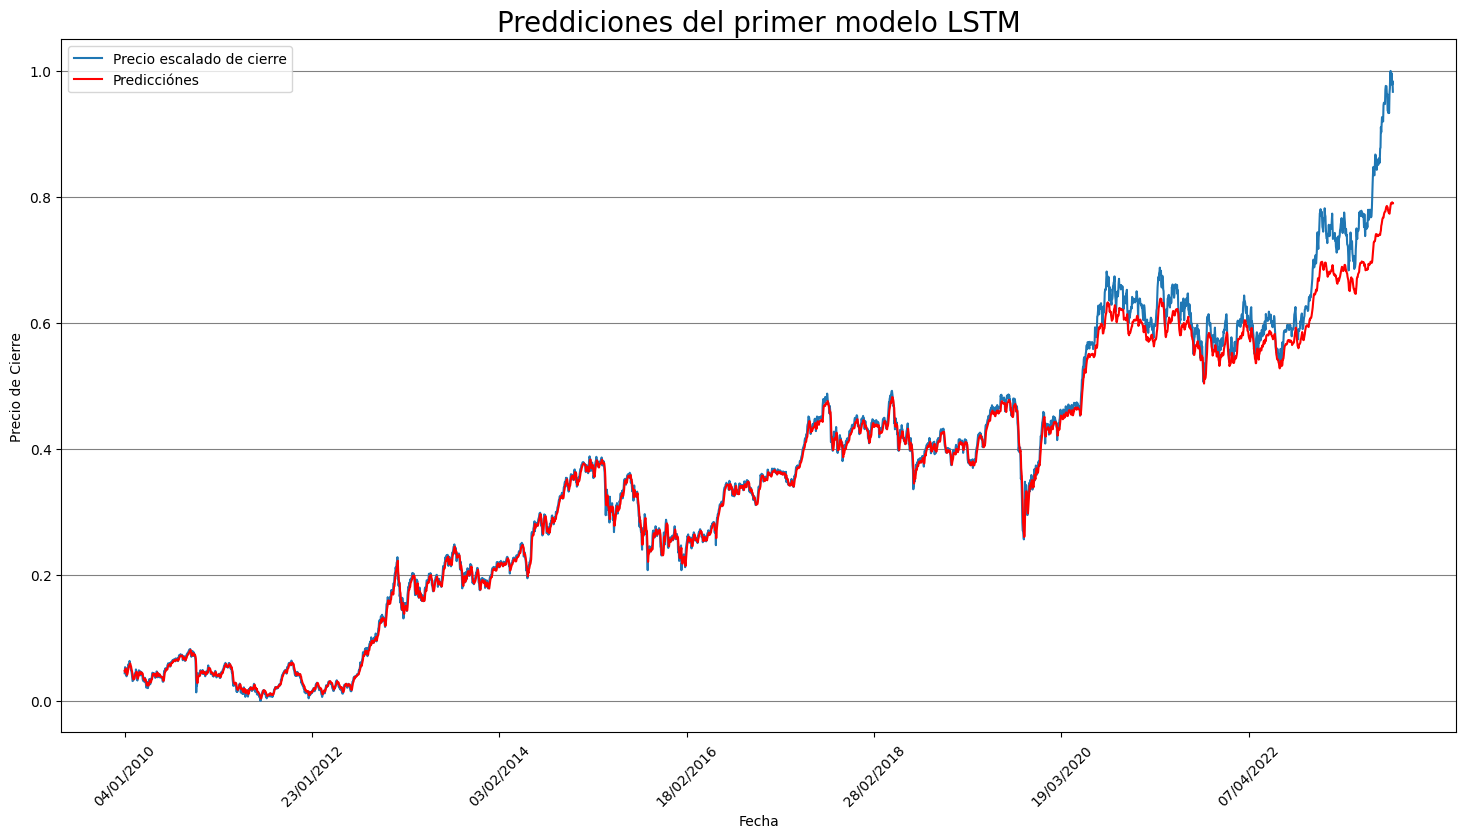

In [15]:
plt.figure(figsize=(18,9))
plt.plot(range(len(datos['Date'][100:])),datos_escalados[100:],label='Precio escalado de cierre')
plt.plot(range(len(datos['Date'][100:])),predicciones3_m1[90:], color="red", label='Predicciónes')

plt.xticks(range(0,len(datos['Date']),500),datos['Date'][0::500],rotation=45)
plt.title('Preddiciones del primer modelo LSTM', fontsize=20)
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.grid(axis='y',color='gray')
plt.legend()
plt.show()